In [97]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt


Running error analysis for different perturbation sizes...
----------------------------------------------------------------------
Processing perturbation scale 1/250: 0.000000
  Error ||AX - BX||_2: 4.507819e-10
rank(B) =  10
  Error ||A - B||_2: 4.219089e-11
Processing perturbation scale 2/250: 0.000000
  Error ||AX - BX||_2: 1.130219e-09
rank(B) =  10
  Error ||A - B||_2: 1.009656e-10
Processing perturbation scale 3/250: 0.000000
  Error ||AX - BX||_2: 2.074277e-09
rank(B) =  10
  Error ||A - B||_2: 2.130952e-10
Processing perturbation scale 4/250: 0.000000
  Error ||AX - BX||_2: 9.459378e-10
rank(B) =  10
  Error ||A - B||_2: 9.665534e-11
Processing perturbation scale 5/250: 0.000000
  Error ||AX - BX||_2: 2.701737e-08
rank(B) =  10
  Error ||A - B||_2: 2.355692e-09
Processing perturbation scale 6/250: 0.000000
  Error ||AX - BX||_2: 2.131026e-09
rank(B) =  10
  Error ||A - B||_2: 2.188310e-10
Processing perturbation scale 7/250: 0.000000
  Error ||AX - BX||_2: 8.124110e-09
rank(B) 

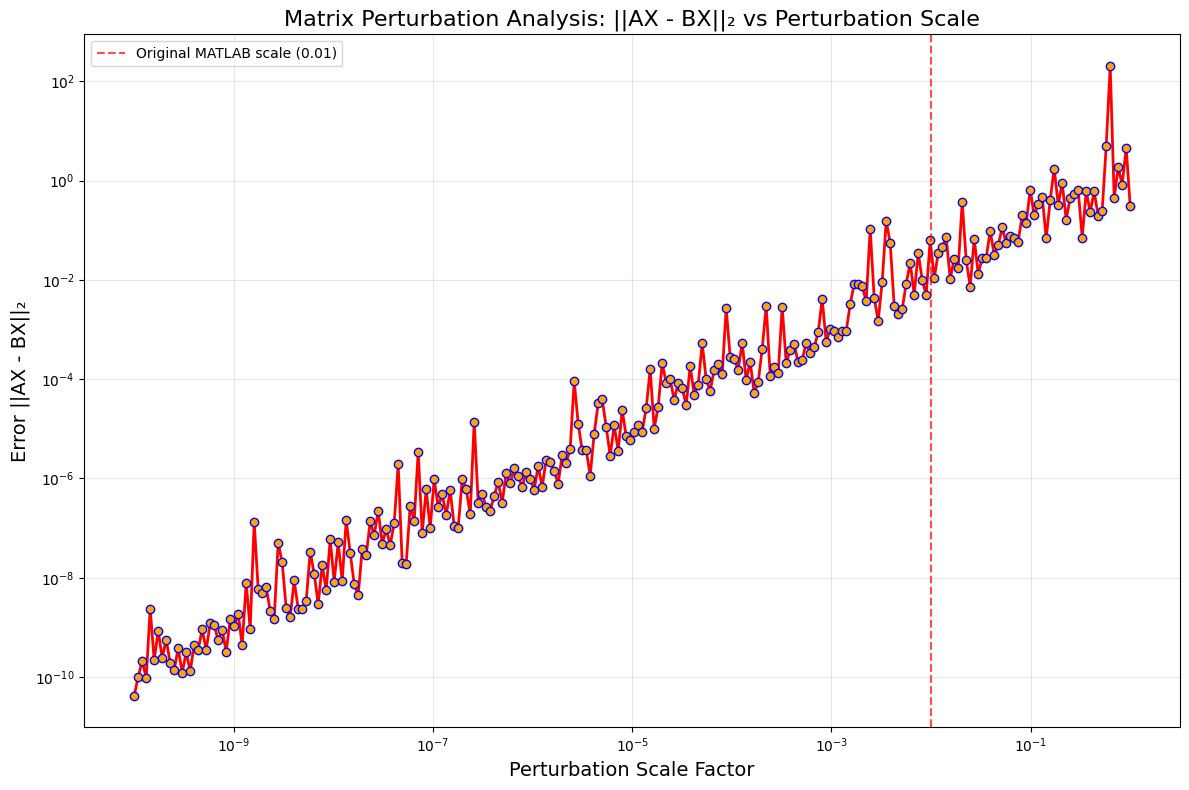

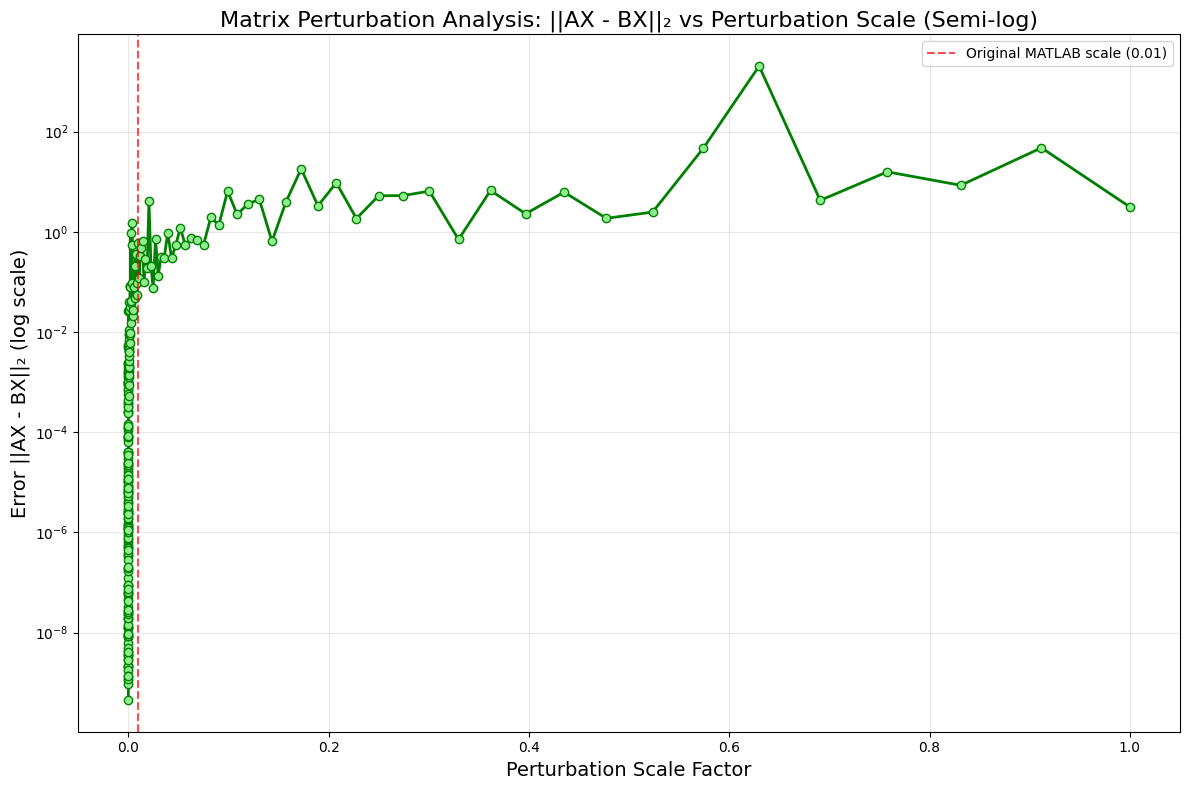


Error Statistics:
Minimum error: 4.507819e-10 at scale 0.000000
Maximum error: 2.045813e+03 at scale 0.629791
Mean error: 9.144285e+00


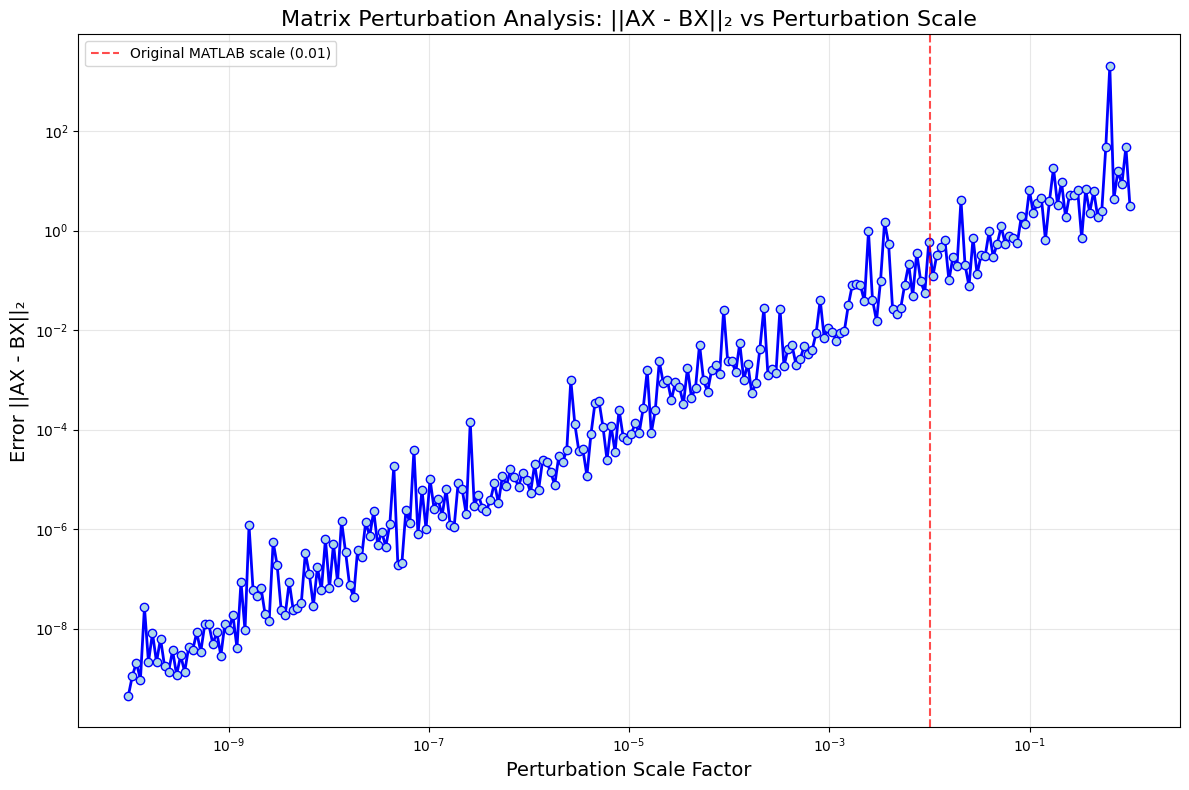

In [98]:

n = 100
r = 10

# Define range of perturbation sizes to test
# Original MATLAB used 0.01, so we'll vary this scaling factor
perturbation_scales = np.logspace(-10, 0, 250)  

# Storage for results
errors_AX_BX = []
perturbation_values = []
trial_values = []

print("Running error analysis for different perturbation sizes...")
print("-" * 70)

for i, pert_scale in enumerate(perturbation_scales):
    print(f"Processing perturbation scale {i+1}/{len(perturbation_scales)}: {pert_scale:.6f}")
    
    # Generate random orthogonal matrix Q (matching MATLAB's qr(randn(n,r),0))
    Q, _ = np.linalg.qr(np.random.randn(n, r))
    
    # Create diagonal matrix matching MATLAB's diag(1:r)/r
    diag_values = np.arange(1, r+1) / r
    A_sym = Q @ np.diag(diag_values) @ Q.T
    
    # Create perturbation with variable scaling factor
    # Original: 0.01./(10.^(r:-1:1)), now: pert_scale./(10.^(r:-1:1))
    perturbation_diag = pert_scale / (10.0 ** np.arange(r, 0, -1))
    Q_p = Q + np.random.randn(n, r) @ np.diag(perturbation_diag)
    
    # QR decomposition of perturbed Q
    Q_pert, _ = np.linalg.qr(Q_p)
    
    # Form near-symmetric matrix A
    A = Q @ np.diag(diag_values) @ Q_pert.T
    
    # Random matrix X and compute AX
    X = np.random.randn(n, r)
    AX = A @ X
    
    try:
        # Nyström approximation
        A_nystrom = AX @ np.linalg.inv(X.T @ AX) @ AX.T
        
        # Skew-symmetric part (nonsymmetry)
        epsilon = A - A.T
        
        # Compute B
        B = A_nystrom + (AX @ np.linalg.inv(X.T @ AX)) @ (X.T @ epsilon @ X) @ np.linalg.pinv(X)
        pepepep = AX @ np.linalg.pinv(X.T @ AX)@(X.T @ epsilon @ X) @ np.linalg.pinv(X)
        
        # Calculate error: ||AX - BX||_2
        bx_ax_error = np.linalg.norm(A_nystrom @ X - B @ X, 2)
        trial_error = np.linalg.norm(pepepep,2)
        rank_B = np.linalg.matrix_rank(B)
        
        
        errors_AX_BX.append(bx_ax_error)
        perturbation_values.append(pert_scale)
        trial_values.append(trial_error)
        
        print(f"  Error ||AX - BX||_2: {bx_ax_error:.6e}")
        print("rank(B) = ", rank_B)
        print(f"  Error ||A - B||_2: {trial_error:.6e}")
        
    except np.linalg.LinAlgError:
        print(f"  Skipping due to singular matrix at perturbation scale {pert_scale:.6f}")
        continue

print("-" * 70)
print(f"Completed analysis for {len(errors_AX_BX)} perturbation scales")

# Create the main plot
plt.figure(figsize=(12, 8))
plt.loglog(perturbation_values, trial_values, 'r-o', linewidth=2, markersize=6, 
           markerfacecolor='orange', markeredgecolor='blue')
plt.xlabel('Perturbation Scale Factor', fontsize=14)
plt.ylabel('Error ||AX - BX||₂', fontsize=14)
plt.title('Matrix Perturbation Analysis: ||AX - BX||₂ vs Perturbation Scale', fontsize=16)
plt.grid(True, alpha=0.3)

# Add reference line for MATLAB's original scale (0.01)
matlab_scale = 0.01
plt.axvline(x=matlab_scale, color='red', linestyle='--', alpha=0.7, 
            label=f'Original MATLAB scale ({matlab_scale})')
plt.legend()
plt.tight_layout()

# Print statistics
print(f"\nError Statistics:")
print(f"Minimum error: {min(errors_AX_BX):.6e} at scale {perturbation_values[np.argmin(errors_AX_BX)]:.6f}")
print(f"Maximum error: {max(errors_AX_BX):.6e} at scale {perturbation_values[np.argmax(errors_AX_BX)]:.6f}")
print(f"Mean error: {np.mean(errors_AX_BX):.6e}")

plt.show()

# Create a second plot with linear scale for better detail
plt.figure(figsize=(12, 8))
plt.semilogy(perturbation_values, errors_AX_BX, 'g-o', linewidth=2, markersize=6,
             markerfacecolor='lightgreen', markeredgecolor='green')
plt.xlabel('Perturbation Scale Factor', fontsize=14)
plt.ylabel('Error ||AX - BX||₂ (log scale)', fontsize=14)
plt.title('Matrix Perturbation Analysis: ||AX - BX||₂ vs Perturbation Scale (Semi-log)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.axvline(x=matlab_scale, color='red', linestyle='--', alpha=0.7, 
            label=f'Original MATLAB scale ({matlab_scale})')
plt.legend()
plt.tight_layout()
plt.show()

# Create the main plot
plt.figure(figsize=(12, 8))
plt.loglog(perturbation_values, errors_AX_BX, 'b-o', linewidth=2, markersize=6, 
           markerfacecolor='lightblue', markeredgecolor='blue')
plt.xlabel('Perturbation Scale Factor', fontsize=14)
plt.ylabel('Error ||AX - BX||₂', fontsize=14)
plt.title('Matrix Perturbation Analysis: ||AX - BX||₂ vs Perturbation Scale', fontsize=16)
plt.grid(True, alpha=0.3)

# Add reference line for MATLAB's original scale (0.01)
matlab_scale = 0.01
plt.axvline(x=matlab_scale, color='red', linestyle='--', alpha=0.7, 
            label=f'Original MATLAB scale ({matlab_scale})')
plt.legend()
plt.tight_layout()

# Print statistics
print(f"\nError Statistics:")
print(f"Minimum error: {min(errors_AX_BX):.6e} at scale {perturbation_values[np.argmin(errors_AX_BX)]:.6f}")
print(f"Maximum error: {max(errors_AX_BX):.6e} at scale {perturbation_values[np.argmax(errors_AX_BX)]:.6f}")
print(f"Mean error: {np.mean(errors_AX_BX):.6e}")

plt.show()

[100.0, 10.0, 1, 0.1, 0.01, 0.01, 0.01, 1e-07, 1e-07, 1e-07]
0.20293418283223985 0.20293418283223985
Error of $\|A_{new} - A_{nystrom}\|_2$ = 1.194572e-12
Symmetry error of A_{new} =  1.194567e-12
Error of $\|A_{new} - A_{nystrom}\|_2$ = 1.760584e-12
Symmetry error of A_{new} =  1.760558e-12
Error of $\|A_{new} - A_{nystrom}\|_2$ = 3.008194e-12
Symmetry error of A_{new} =  3.008324e-12
Error of $\|A_{new} - A_{nystrom}\|_2$ = 5.204130e-12
Symmetry error of A_{new} =  5.204164e-12
Error of $\|A_{new} - A_{nystrom}\|_2$ = 9.590136e-12
Symmetry error of A_{new} =  9.590006e-12
Error of $\|A_{new} - A_{nystrom}\|_2$ = 1.700314e-11
Symmetry error of A_{new} =  1.700320e-11
Error of $\|A_{new} - A_{nystrom}\|_2$ = 3.006162e-11
Symmetry error of A_{new} =  3.006168e-11
Error of $\|A_{new} - A_{nystrom}\|_2$ = 4.847850e-11
Symmetry error of A_{new} =  4.847838e-11
Error of $\|A_{new} - A_{nystrom}\|_2$ = 8.728750e-11
Symmetry error of A_{new} =  8.728752e-11
Error of $\|A_{new} - A_{nystrom}\|

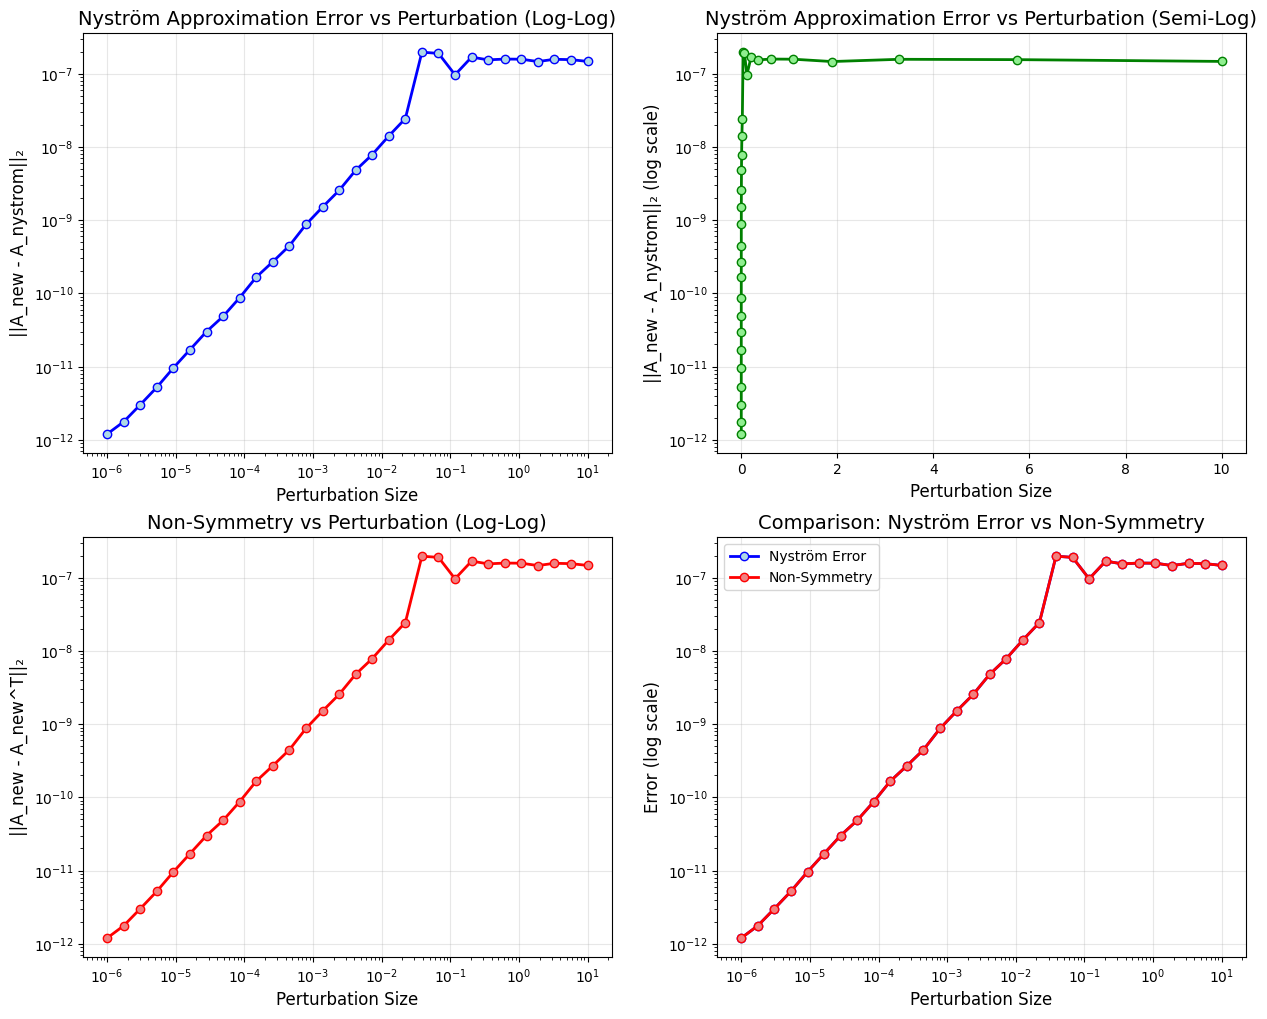

In [ ]:
exp_values = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2]
exp_values_reversed = exp_values[::-1]



A_sym_new = Q @ np.diag(exp_values_reversed) @ Q.T
print(A_sym_new[5,0], A_sym_new[0,5])


small_sv_indices = [-3, -2, -1]  # or range(-3, 0) or [7, 8, 9] for r=10
perturbation_size = np.logspace(-6,1,30)

new_error = []
gradual_symmetric_error = []

for i, pert_size in enumerate(perturbation_size):

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    for j in small_sv_indices:
        Q_pert_new[:, j] += pert_size * np.random.randn(n)

    # Re-orthogonalize to maintain orthogonality
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A_new = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    error_new_nystrom = np.linalg.norm(A_sym_new - A_new,2)

    new_error.append(error_new_nystrom)

    symmetry_err = np.linalg.norm(A_sym_new - A_new.T,2)

    gradual_symmetric_error.append(symmetry_err)

    #print(r'Error of $\|A_{new} - A_{nystrom}\|_2$ =', f"{error_new_nystrom:.6e}")
    #print(r'Symmetry error of A_{new} = ', f"{symmetry_err:.6e}")

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Log-log plot of Nyström error vs perturbation size
ax1.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=6,
           markerfacecolor='lightblue', markeredgecolor='blue')
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel('||A_new - A_nystrom||₂', fontsize=12)
ax1.set_title('Nyström Approximation Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Semi-log plot of Nyström error vs perturbation size
ax2.semilogy(perturbation_size, new_error, 'g-o', linewidth=2, markersize=6,
             markerfacecolor='lightgreen', markeredgecolor='green')
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel('||A_new - A_nystrom||₂ (log scale)', fontsize=12)
ax2.set_title('Nyström Approximation Error vs Perturbation (Semi-Log)', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-log plot of non-symmetry vs perturbation size
ax3.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=6,
           markerfacecolor='lightcoral', markeredgecolor='red')
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel('||A_new - A_new^T||₂', fontsize=12)
ax3.set_title('Non-Symmetry vs Perturbation (Log-Log)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=6,
           markerfacecolor='lightblue', markeredgecolor='blue', label='Nyström Error')
ax4.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=6,
           markerfacecolor='lightcoral', markeredgecolor='red', label='Non-Symmetry')
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Nyström Error vs Non-Symmetry', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()







Eigenvalues (largest to smallest): [100.0, 10.0, 1, 0.1, 0.01, 0.01, 0.01, 1e-07, 1e-07, 1e-07]
Verification of symmetry: A[5,0] = 2.029342e-01, A[0,5] = 2.029342e-01
Nyström approximation error for symmetric matrix: 5.190574e-04

Running perturbation analysis...
------------------------------------------------------------
Processing perturbation 1/20: 0.000100
  Nyström error: 5.190574e-04, Non-symmetry: 1.064132e-10
Processing perturbation 2/20: 0.000183
  Nyström error: 5.190574e-04, Non-symmetry: 2.076274e-10
Processing perturbation 3/20: 0.000336
  Nyström error: 5.190574e-04, Non-symmetry: 3.973207e-10
Processing perturbation 4/20: 0.000616
  Nyström error: 5.190574e-04, Non-symmetry: 6.988222e-10
Processing perturbation 5/20: 0.001129
  Nyström error: 5.190574e-04, Non-symmetry: 1.245967e-09
Processing perturbation 6/20: 0.002069
  Nyström error: 5.190574e-04, Non-symmetry: 2.381486e-09
Processing perturbation 7/20: 0.003793
  Nyström error: 5.190574e-04, Non-symmetry: 4.028329e

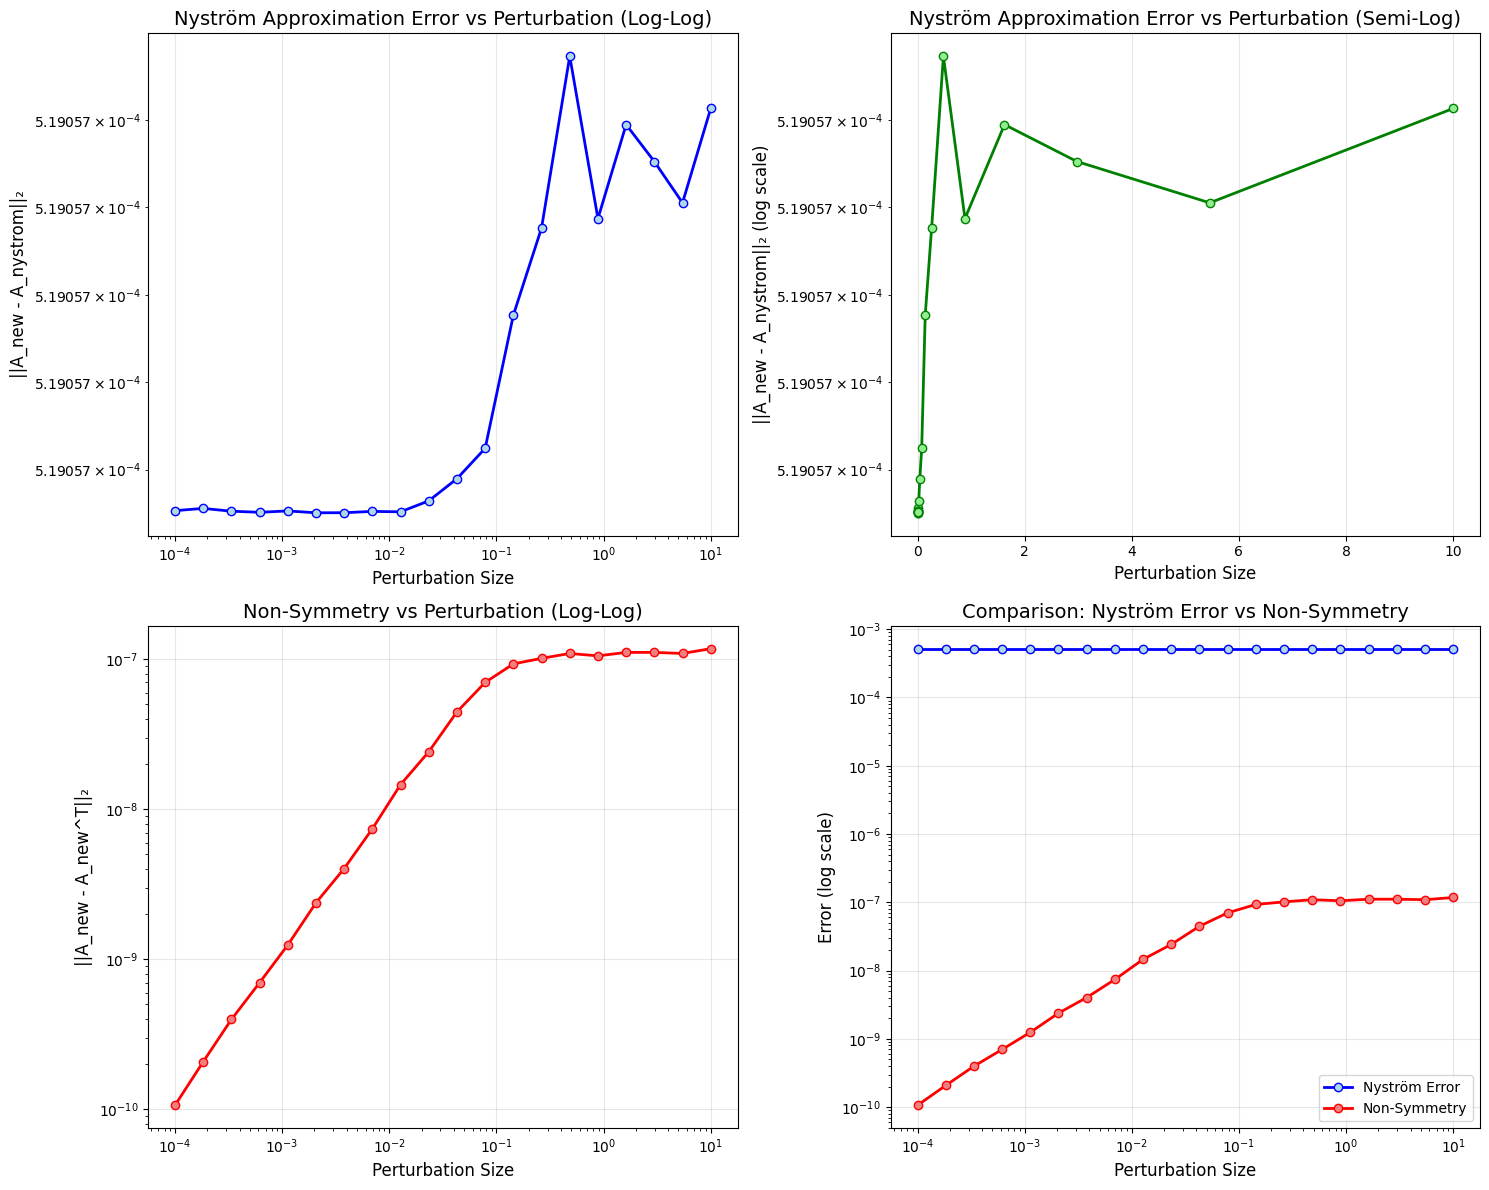


Summary Statistics:
Perturbation range: 1.000000e-04 to 1.000000e+01
Nyström error range: 5.190574e-04 to 5.190574e-04
Non-symmetry range: 1.064132e-10 to 1.176510e-07

Correlations (in log space):
Perturbation vs Nyström error: 0.8719
Perturbation vs Non-symmetry: 0.9443


In [102]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n = 100
r = 10

# Generate base orthogonal matrix Q
Q, _ = np.linalg.qr(np.random.randn(n, r))

# Define eigenvalue spectrum with different orders of magnitude
exp_values = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2]
exp_values_reversed = exp_values[::-1]
print("Eigenvalues (largest to smallest):", exp_values_reversed)

# Create the reference symmetric matrix
A_sym_new = Q @ np.diag(exp_values_reversed) @ Q.T
print(f"Verification of symmetry: A[5,0] = {A_sym_new[5,0]:.6e}, A[0,5] = {A_sym_new[0,5]:.6e}")

# Create Nyström approximation for the symmetric matrix
X = np.random.randn(n, r)
AX_sym = A_sym_new @ X
A_nystrom = AX_sym @ np.linalg.inv(X.T @ AX_sym) @ AX_sym.T

print(f"Nyström approximation error for symmetric matrix: {np.linalg.norm(A_sym_new - A_nystrom, 2):.6e}")

# Define perturbation parameters
small_sv_indices = [-3, -2, -1]  # Indices of smallest singular values
perturbation_sizes = np.logspace(-4, 1, 20)  # From 1e-4 to 10

# Storage for results
nystrom_errors = []
symmetry_errors = []
successful_perturbations = []

print("\nRunning perturbation analysis...")
print("-" * 60)

for i, pert_size in enumerate(perturbation_sizes):
    print(f"Processing perturbation {i+1}/{len(perturbation_sizes)}: {pert_size:.6f}")
    
    try:
        # Create targeted perturbation (fixed: use pert_size instead of perturbation_size)
        Q_pert_new = Q.copy()
        for j in small_sv_indices:
            Q_pert_new[:, j] += pert_size * np.random.randn(n)
        
        # Re-orthogonalize to maintain orthogonality
        Q_pert_new, _ = np.linalg.qr(Q_pert_new)
        
        # Create the near-symmetric matrix
        A_new = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T
        
        # Calculate error between near-symmetric matrix and Nyström approximation
        nystrom_error = np.linalg.norm(A_new - A_nystrom, 2)
        
        # Calculate degree of non-symmetry
        symmetry_error = np.linalg.norm(A_new - A_new.T, 2)
        
        # Store results
        nystrom_errors.append(nystrom_error)
        symmetry_errors.append(symmetry_error)
        successful_perturbations.append(pert_size)
        
        print(f"  Nyström error: {nystrom_error:.6e}, Non-symmetry: {symmetry_error:.6e}")
        
    except np.linalg.LinAlgError as e:
        print(f"  Skipping due to numerical error: {e}")
        continue

print("-" * 60)
print(f"Completed analysis for {len(successful_perturbations)} perturbation sizes")

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Log-log plot of Nyström error vs perturbation size
ax1.loglog(successful_perturbations, nystrom_errors, 'b-o', linewidth=2, markersize=6,
           markerfacecolor='lightblue', markeredgecolor='blue')
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel('||A_new - A_nystrom||₂', fontsize=12)
ax1.set_title('Nyström Approximation Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Semi-log plot of Nyström error vs perturbation size
ax2.semilogy(successful_perturbations, nystrom_errors, 'g-o', linewidth=2, markersize=6,
             markerfacecolor='lightgreen', markeredgecolor='green')
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel('||A_new - A_nystrom||₂ (log scale)', fontsize=12)
ax2.set_title('Nyström Approximation Error vs Perturbation (Semi-Log)', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-log plot of non-symmetry vs perturbation size
ax3.loglog(successful_perturbations, symmetry_errors, 'r-o', linewidth=2, markersize=6,
           markerfacecolor='lightcoral', markeredgecolor='red')
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel('||A_new - A_new^T||₂', fontsize=12)
ax3.set_title('Non-Symmetry vs Perturbation (Log-Log)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(successful_perturbations, nystrom_errors, 'b-o', linewidth=2, markersize=6,
           markerfacecolor='lightblue', markeredgecolor='blue', label='Nyström Error')
ax4.loglog(successful_perturbations, symmetry_errors, 'r-o', linewidth=2, markersize=6,
           markerfacecolor='lightcoral', markeredgecolor='red', label='Non-Symmetry')
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Nyström Error vs Non-Symmetry', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Perturbation range: {min(successful_perturbations):.6e} to {max(successful_perturbations):.6e}")
print(f"Nyström error range: {min(nystrom_errors):.6e} to {max(nystrom_errors):.6e}")
print(f"Non-symmetry range: {min(symmetry_errors):.6e} to {max(symmetry_errors):.6e}")

# Calculate correlation between perturbation size and errors
correlation_nystrom = np.corrcoef(np.log10(successful_perturbations), np.log10(nystrom_errors))[0,1]
correlation_symmetry = np.corrcoef(np.log10(successful_perturbations), np.log10(symmetry_errors))[0,1]

print(f"\nCorrelations (in log space):")
print(f"Perturbation vs Nyström error: {correlation_nystrom:.4f}")
print(f"Perturbation vs Non-symmetry: {correlation_symmetry:.4f}")